In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [53]:

label = 'h_0.4_p_0.8_q_0.1'
file = open("data_{}.txt".format(label))

realisations = []
flag = True 
L = 255

n = 0 

while n < 10: 
    line = file.readline() 
    if line[0] == '#':
        flag = True 
        print(line)
    else: 
        if flag:  
            new_realisation = [line]
            realisations.append(new_realisation)
            n += 1 
            flag = False
        else:
            new_realisation.append(line)
            
realisations = realisations[:-1]

#Parameters={ Seed: 5, Branching rate: 0.4, p : 0.8, q : 0.1, Realisations: 10, Chunk size: 10, Dimension: 2, (Max) Lattice size: 255, Graph Type: 0 }

#Version: #6ebb

# Running for L = 255

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 



In [54]:
def extract_evolution(realisation): 
    evolution = []
    edges = [] 
    msds = [] 
    counts = [] 
    passive_flag = False 
    active_flag = False
    for line in realisation:  
        if line.startswith('count'):
            counts.append(float(line[6:-1]))
        if line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
            passive_flag = True 
        elif line.startswith('active'):
            active_indices = np.fromstring(line[7:-1], sep=',')
            active_indices = np.unravel_index(active_indices.astype('int'), (L, L))
            active_flag = True 
        elif line.startswith('msd'):
            msds.append(float(line[4:-1]))
        elif line.startswith('edge'): 
            edges.append(np.fromstring(line[5:-1], sep=','))
        else: 
            snapshot = np.zeros((L, L)) # clear the snapshot for the next time slice 
            
        if passive_flag and active_flag: 
            snapshot[passive_indices] = 1 # set occupied sites to -1 
            snapshot[active_indices] = 2
#             for (i,j) in zip(*active_indices):
#                 snapshot[i, j] += 1 
            evolution.append(snapshot)
            passive_flag = False 
            active_flag = False 
            
    return np.array(edges), np.array(msds), np.array(counts), np.array(evolution)

def make_movies(evolution, label):
    fig = plt.figure(figsize=(20, 20))
    ims = []
    plt.axis('off')
    for xy in evolution:
        im = plt.imshow(xy, animated=True, vmin=0, vmax=2, cmap='Blues', origin='lower') 
        plt.axis('off')
        ims.append([im])
        
    ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    mywriter = am.FFMpegWriter()
    ani.save("{}_movie_{}.mp4".format(label, i), writer=mywriter)
    plt.close()  
    
        

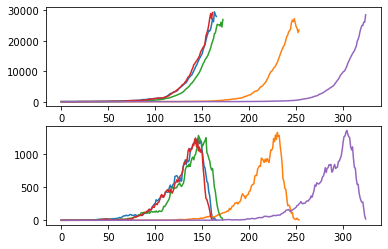

In [55]:
_, axes = plt.subplots(2)
for (i, realisation) in enumerate(realisations[:5]):
    edges, msds, counts, evolution = extract_evolution(realisation) 
    make_movies(evolution, label)
    axes[0].plot(msds)
    axes[1].plot(counts)
    

In [28]:
print(edges.shape, msds.shape, counts.shape, evolution.shape)

(37, 2) (0,) (0,) (1, 127, 127)


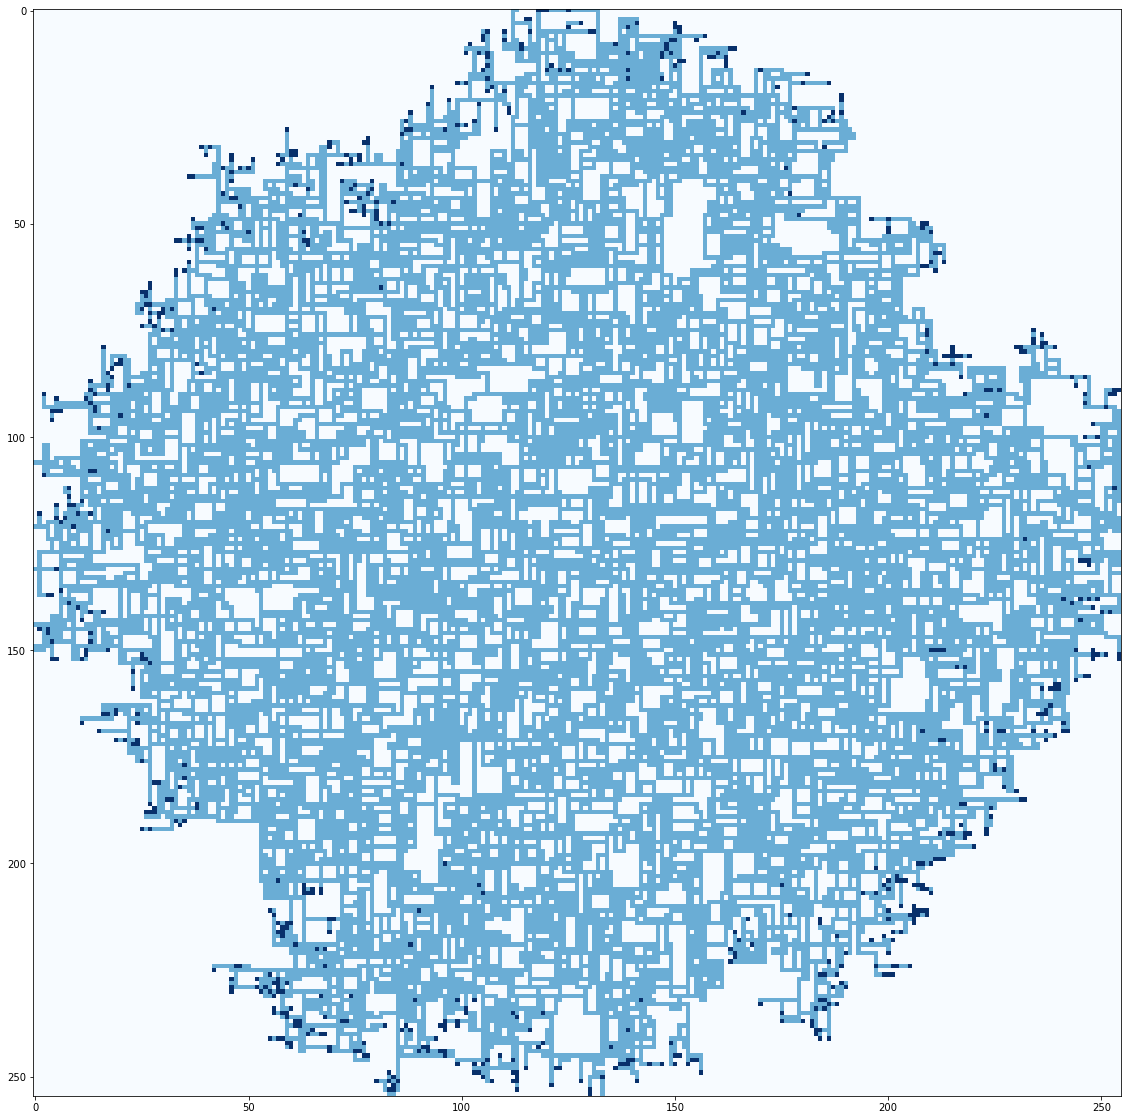

In [58]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(evolution[-20], vmin=0, vmax=2, interpolation='none', cmap="Blues")
plt.show() 